# Assignment 1: Bag of Words, Naive Bayes, Support Vector Machines, Decision/Regression Trees

### INtegrante:
JOEL MATEO MANRIQUE VELASQUEZ 
GINNO 
LUIS

# ============================================
# PART A: BINARY CLASSIFICATION ON TEXT DATA
# NLP with Disaster Tweets Dataset
# ============================================

In [5]:
# Requisitos: pip install scikit-learn pandas nltk
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.naive_bayes import BernoulliNB
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [21]:
### 1) Cargar datos y porcentajes
df = pd.read_csv("C:/Users/Luis Enrique/Music/luis enrique/INEI/clases/PEU/Prof. Alex/ENEI-2025-ML2-Tarea1-main/data/disaster_tweets.csv")  # ajusta ruta
print(df.head())
print("\nPorcentaje de tweets reales y no reales:")
print(df['target'].value_counts(normalize=True) * 100)  # % por clase

### 2) Split 70/30 estratificado
X = df['text'].fillna('')
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Porcentaje de tweets reales y no reales:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


In [ ]:
# 3) Preprocesamiento del texto (función)
stop_words = set(stopwords.words('english'))
# conservar negaciones si quieres: stop_words -= {'not', "n't"}

lemmatizer = WordNetLemmatizer()
url_re = re.compile(r'https?://\S+|www\.\S+')
mention_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#(\w+)')  # opcionalmente extraer palabra
non_alpha_re = re.compile(r'[^a-zA-Z0-9\s]')

def preprocess(text):
    text = str(text)
    text = url_re.sub('', text)          # quitar urls
    text = mention_re.sub('', text)      # quitar menciones
    # extraer hashtag text (si quieres conservar): text = hashtag_re.sub(r'\1', text)
    text = text.lower()
    text = non_alpha_re.sub(' ', text)   # quitar puntuacion
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if len(t) > 1]  # quitar tokens de 1 char
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Aplicar (puede llevar tiempo)
X_train_p = X_train.apply(preprocess)
X_test_p  = X_test.apply(preprocess)

In [22]:
### 4) Bag of Words binario
# Se crea la representación binaria (1 si la palabra está presente, 0 si no).
# Se usa un umbral min_df=5 para ignorar palabras muy raras.
# Elegir min_df M: sugerencia inicial M = 5 (o min_df=0.001 para %)
min_df_choice = 5
vectorizer = CountVectorizer(binary=True, min_df=min_df_choice)
vectorizer.fit(X_train_p)
Xtr = vectorizer.transform(X_train_p)
Xte = vectorizer.transform(X_test_p)
print("\nTamaño del vocabulario:", len(vectorizer.vocabulary_))


Tamaño del vocabulario: 1952


In [ ]:
### 5) Logistic Regression sin regularización
# sklearn acepta penalty='none' with solver='saga' for multinomial/binary
lr_none = LogisticRegression(penalty=None, solver='saga', max_iter=5000, random_state=42)
lr_none.fit(Xtr, y_train)
ytr_pred = lr_none.predict(Xtr)
yte_pred = lr_none.predict(Xte)
print("LR no-regularization F1 train:", f1_score(y_train, ytr_pred))
print("LR no-regularization F1 test:",  f1_score(y_test, yte_pred))


LR no-regularization F1 train: 0.9628811312417145
LR no-regularization F1 test: 0.7027027027027027


In [ ]:
### 6) Logistic Regression L1 (buscar C con CV)
# usare saga solver que soporta l1
param_grid = {'C': np.logspace(-4, 4, 10)}
lr_l1 = GridSearchCV(
    LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42),
    param_grid, scoring='f1', cv=5, n_jobs=-1
)
lr_l1.fit(Xtr, y_train)
print("Best C (L1):", lr_l1.best_params_, "best CV f1:", lr_l1.best_score_)
best_l1 = lr_l1.best_estimator_
ytr_pred = best_l1.predict(Xtr)
yte_pred = best_l1.predict(Xte)
print("LR L1 F1 train:", f1_score(y_train, ytr_pred))
print("LR L1 F1 test:",  f1_score(y_test, yte_pred))


Best C (L1): {'C': np.float64(2.782559402207126)} best CV f1: 0.7282771991614215
LR L1 F1 train: 0.8962242821614289
LR L1 F1 test: 0.735140771637122


In [ ]:
### 7) Logistic Regression con regularización L2

print("\n=== Logistic Regression con L2 regularización ===")
lr_l2 = GridSearchCV(
    LogisticRegression(penalty='l2', solver='saga', max_iter=5000, random_state=42),
    param_grid, scoring='f1', cv=5, n_jobs=-1
)
lr_l2.fit(Xtr, y_train)
print("Mejor C (L2):", lr_l2.best_params_, " | Mejor F1 CV:", lr_l2.best_score_)

best_l2 = lr_l2.best_estimator_
ytr_pred = best_l2.predict(Xtr)
yte_pred = best_l2.predict(Xte)
print("F1 Train (L2):", f1_score(y_train, ytr_pred))
print("F1 Test  (L2):", f1_score(y_test, yte_pred))


=== Logistic Regression con L2 regularización ===
Mejor C (L2): {'C': np.float64(0.3593813663804626)}  | Mejor F1 CV: 0.7432242891581426
F1 Train (L2): 0.8352219074598678
F1 Test  (L2): 0.756311745334797


In [24]:
### 8) Inspeccionar coef vector (L1): palabras más importantes
print("\n=== Palabras más importantes según L1 ===")
coefs = best_l1.coef_.ravel()
vocab = vectorizer.get_feature_names_out()
# Top positive (disaster) and top negative
top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]
print("\nTop palabras indicativas de desastre:")
for i in top_pos_idx[:20]:
    print(vocab[i], coefs[i])
print("\nTop palabras indicativas de no desastre:")
for i in top_neg_idx[:20]:
    print(vocab[i], coefs[i])


=== Palabras más importantes según L1 ===

Top palabras indicativas de desastre:
spill 5.83944103772973
typhoon 5.3959507539472735
airport 4.987913639808743
distance 4.845601319101352
learning 4.673691247872319
migrant 4.654518635861254
debris 4.516010440173814
wildfire 4.442184373377002
japanese 4.378080717632308
grateful 4.247848362987968
derailment 4.08820702036518
horrible 4.069054188833885
hiroshima 3.9740029683044127
outbreak 3.921441806571281
onto 3.8532010707678364
confirmed 3.771955178764787
needed 3.732796151482708
aid 3.720204180442558
bombing 3.5367761285587154
wmata 3.499944712039459

Top palabras indicativas de no desastre:
ticket -4.68065489646827
build -4.519370408969247
technology -4.221729579397013
ice -3.978442136148323
poll -3.856665692452776
led -3.6744511879078714
character -3.4037126811444076
career -3.3738354961051966
grade -3.270728051867685
appears -3.2525853302517467
republican -3.2487365248414872
facebook -3.224872267778339
lmao -3.1675398608892684
wedding 

In [ ]:
### 9) Bernoulli Naive Bayes (sklearn)
bnb = BernoulliNB(alpha=1.0)
bnb.fit(Xtr, y_train)
print("BernoulliNB F1 train:", f1_score(y_train, bnb.predict(Xtr)))
print("BernoulliNB F1 test:",  f1_score(y_test,  bnb.predict(Xte)))

BernoulliNB F1 train: 0.7979749276759884
BernoulliNB F1 test: 0.754951895868704


In [ ]:
### 10) Bernoulli NB IMPLEMENTACIÓN MANUAL (simple)
# suponiendo Xtr binario matrix (csr) y y_train
from scipy.sparse import csr_matrix
def bernoulli_nb_train(X_bin, y, alpha=1.0):
    # X_bin: scipy csr_matrix with binary features
    n_docs, n_feat = X_bin.shape
    y = np.array(y)
    phi_y1 = (y==1).mean()  # p(y=1)
    # counts of feature present for each class
    X_arr = X_bin.toarray()  # OJO: para vocab grande puede explotar memoria; usar sums on sparse
    # Better: do sparse sums:
    X_present_sum_pos = X_bin[y==1].sum(axis=0).A1
    X_present_sum_neg = X_bin[y==0].sum(axis=0).A1
    n_pos = (y==1).sum()
    n_neg = (y==0).sum()
    # p(x_i=1 | y=1) with Laplace
    p_x1_y1 = (X_present_sum_pos + alpha) / (n_pos + 2*alpha)
    p_x1_y0 = (X_present_sum_neg + alpha) / (n_neg + 2*alpha)
    return {'phi_y1':phi_y1, 'p_x1_y1':p_x1_y1, 'p_x1_y0':p_x1_y0}

def bernoulli_nb_predict(X_bin, model):
    # compute log posterior
    Xarr = X_bin.toarray()
    log_p_x1_y1 = np.log(model['p_x1_y1'])
    log_p_x0_y1 = np.log(1 - model['p_x1_y1'])
    log_p_x1_y0 = np.log(model['p_x1_y0'])
    log_p_x0_y0 = np.log(1 - model['p_x1_y0'])
    # log-likelihood per doc:
    log_like_y1 = Xarr.dot(log_p_x1_y1) + (1-Xarr).dot(log_p_x0_y1) + np.log(model['phi_y1'])
    log_like_y0 = Xarr.dot(log_p_x1_y0) + (1-Xarr).dot(log_p_x0_y0) + np.log(1-model['phi_y1'])
    return (log_like_y1 > log_like_y0).astype(int)

model_bnb = bernoulli_nb_train(Xtr, y_train, alpha=1.0)
ytr_pred = bernoulli_nb_predict(Xtr, model_bnb)
yte_pred = bernoulli_nb_predict(Xte, model_bnb)
print("Manual BernoulliNB F1 train:", f1_score(y_train, ytr_pred))
print("Manual BernoulliNB F1 test:",  f1_score(y_test, yte_pred))

Manual BernoulliNB F1 train: 0.7979749276759884
Manual BernoulliNB F1 test: 0.754951895868704


In [ ]:
### 11) NGRAMS (2-grams)
min_df_2gram = 5  # sugerencia: 2-grams son más raros -> usar M >= 5
vec2 = CountVectorizer(binary=True, ngram_range=(2,2), min_df=min_df_2gram)
vec2.fit(X_train_p)
Xtr2 = vec2.transform(X_train_p)
Xte2 = vec2.transform(X_test_p)
print("2-gram vocab size:", len(vec2.vocabulary_))
# mostrar 10 2-grams
print(list(vec2.vocabulary_.keys())[:10])

# Entrenar LR (por ejemplo L2 con C óptimo)
lr2 = GridSearchCV(LogisticRegression(penalty='l2', solver='saga', max_iter=5000), param_grid, scoring='f1', cv=5, n_jobs=-1)
lr2.fit(Xtr2, y_train)
print("LR on 2-grams: best C", lr2.best_params_, "CV f1", lr2.best_score_)
print("LR 2-grams F1 train:", f1_score(y_train, lr2.predict(Xtr2)))
print("LR 2-grams F1 test:",  f1_score(y_test,  lr2.predict(Xte2)))

# Bernoulli NB on 2-grams
bnb2 = BernoulliNB(alpha=1.0)
bnb2.fit(Xtr2, y_train)
print("Bernoulli 2-grams F1 train:", f1_score(y_train, bnb2.predict(Xtr2)))
print("Bernoulli 2-grams F1 test:",  f1_score(y_test,  bnb2.predict(Xte2)))

2-gram vocab size: 589
['red light', 'feel like', 'take quiz', 'pandemonium aba', 'aba woman', 'woman delivers', 'delivers baby', 'baby without', 'without face', 'face photo']
LR on 2-grams: best C {'C': np.float64(10000.0)} CV f1 0.5339161388807077
LR 2-grams F1 train: 0.558991293905734
LR 2-grams F1 test: 0.5366876310272537
Bernoulli 2-grams F1 train: 0.5022335673261008
Bernoulli 2-grams F1 test: 0.4941002949852507


In [25]:
### 12) Comparación final de modelos
print("\n=== Comparación resumida de modelos (F1 test) ===")
models_summary = {
    "LR (sin regularización)": f1_score(y_test, lr_none.predict(Xte)),
    "LR (L1)": f1_score(y_test, best_l1.predict(Xte)),
    "LR (L2)": f1_score(y_test, best_l2.predict(Xte)),
    "NB (Bernoulli sklearn)": f1_score(y_test, bnb.predict(Xte)),
    "NB (Bernoulli manual)": f1_score(y_test, yte_pred),
    "LR (2-grams)": f1_score(y_test, lr2.predict(Xte2)),
    "NB (2-grams)": f1_score(y_test, bnb2.predict(Xte2))
}
for k,v in models_summary.items():
    print(f"{k:30s}: {v:.4f}")

print("\nConclusión: Regularizar (L1/L2) ayuda a reducir el sobreajuste. "
      "El modelo con L2 o el NB suelen equilibrar bien entre bias y varianza. "
      "El uso de 2-grams puede captar más contexto, pero aumenta la dimensionalidad.")


=== Comparación resumida de modelos (F1 test) ===
LR (sin regularización)       : 0.7027
LR (L1)                       : 0.7351
LR (L2)                       : 0.7563
NB (Bernoulli sklearn)        : 0.7550
NB (Bernoulli manual)         : 0.7563
LR (2-grams)                  : 0.5367
NB (2-grams)                  : 0.4941

Conclusión: Regularizar (L1/L2) ayuda a reducir el sobreajuste. El modelo con L2 o el NB suelen equilibrar bien entre bias y varianza. El uso de 2-grams puede captar más contexto, pero aumenta la dimensionalidad.


# Part B 

## 1) Generate Data

Shapes: (215, 2) (93, 2)
Class balance (train, test): 0.5023255813953489 0.4946236559139785


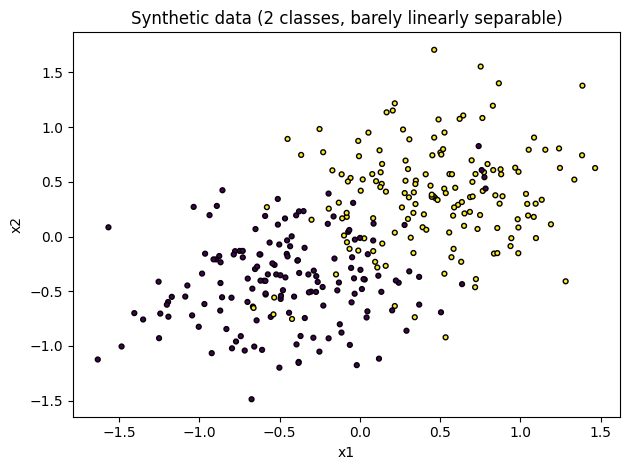

In [3]:
# Pregunta 1: Generar datos sintéticos (2 features, 2 clases)

import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Semilla para hacer reproducible la generación aleatoria (mismos datos cada corrida)
np.random.seed(123)

# Cantidad de puntos por clase principal
n_per_class = 150

# Medias de cada clase (separadas en el plano, casi separables linealmente)
mean_pos, mean_neg = np.array([0.45, 0.45]), np.array([-0.45, -0.45])

cov = np.array([[0.18, 0.0],
                [0.0, 0.18]])

# Muestras gaussianas para cada clase (positiva y negativa)
X_pos = np.random.multivariate_normal(mean_pos, cov, n_per_class)
X_neg = np.random.multivariate_normal(mean_neg, cov, n_per_class)

# Pequeña cantidad de "outliers" cruzados para evitar separabilidad perfecta
n_out = 8
out_pos = np.random.multivariate_normal(np.array([-0.70, -0.60]), 0.02*np.eye(2), n_out // 2)  
out_neg = np.random.multivariate_normal(np.array([ 0.70,  0.60]), 0.02*np.eye(2), n_out // 2)  

# Unimos todo: X (características) y y (etiquetas 0/1)
X = np.vstack([X_pos, X_neg, out_pos, out_neg])
y = np.hstack([
    np.ones(n_per_class),            
    np.zeros(n_per_class),           
    np.ones(n_out // 2),            
    np.zeros(n_out // 2)             
])

# División 70/30 estratificada para conservar la proporción de clases en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Chequeo rápido de shapes y balance de clases
print("Shapes:", X_train.shape, X_test.shape)
print("Class balance (train, test):", y_train.mean(), y_test.mean())

# Gráfico simple 
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, s=12, edgecolor="k")
plt.title("Synthetic data (2 classes, barely linearly separable)")
plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout()



## 2) Test a Variety of C's
### 2.1 Cross-validation error rates and training misclassifications (per C)


In [4]:
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

Cs = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100], dtype=float)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

rows = []
for C in Cs:
    # Entrenar en TODO el train para medir training
    clf = SVC(kernel='linear', C=C, random_state=123).fit(X_train, y_train)
    yhat_tr = clf.predict(X_train)
    train_err = 1.0 - accuracy_score(y_train, yhat_tr)
    train_mis = int((yhat_tr != y_train).sum())

    # Validación cruzada (ajusta dentro de cada fold)
    cv_scores = cross_val_score(
        SVC(kernel='linear', C=C, random_state=123),
        X_train, y_train, cv=skf, scoring='accuracy'
    )
    cv_err = 1.0 - cv_scores.mean()
    cv_std = cv_scores.std()

    rows.append({
        "C": C,
        "train_misclassified": train_mis,
        "train_error": train_err,
        "cv_error": cv_err,
        "cv_std": cv_std
    })

results_cv_train = pd.DataFrame(rows).sort_values("C").reset_index(drop=True)
results_cv_train_rounded = results_cv_train.round(6)
results_cv_train_rounded


,C,train_misclassified,train_error,cv_error,cv_std
0,0.01,24,0.111628,0.106977,0.034806
1,0.03,22,0.102326,0.097674,0.027121
2,0.10,21,0.097674,0.097674,0.027121
3,0.30,20,0.093023,0.093023,0.020801
4,1.00,22,0.102326,0.111628,0.017403
5,3.00,22,0.102326,0.106977,0.011393
6,10.00,21,0.097674,0.102326,0.011393
7,30.00,21,0.097674,0.106977,0.011393
8,100.00,20,0.093023,0.106977,0.011393


### 2.2 Test errors per C and best-by-criterion

In [5]:
import pandas as pd, numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# results_cv_train debe venir de la Parte 2 (contiene columnas: C, train_error, cv_error)
test_rows = []
for C in results_cv_train["C"].values:
    clf = SVC(kernel='linear', C=C, random_state=123).fit(X_train, y_train)
    yhat_te = clf.predict(X_test)
    test_err = 1.0 - accuracy_score(y_test, yhat_te)
    test_mis = int((yhat_te != y_test).sum())
    test_rows.append({"C": C, "test_error": test_err, "test_misclassified": test_mis})

results_test = pd.DataFrame(test_rows).sort_values("C").reset_index(drop=True)

# Ganadores por criterio (primer mínimo)
idx_train_best = results_cv_train["train_error"].idxmin()
idx_cv_best    = results_cv_train["cv_error"].idxmin()
idx_test_best  = results_test["test_error"].idxmin()

summary = pd.DataFrame({
    "criterion": ["min_train_error", "min_cv_error", "min_test_error"],
    "C": [results_cv_train.loc[idx_train_best, "C"],
          results_cv_train.loc[idx_cv_best,   "C"],
          results_test.loc[idx_test_best,     "C"]],
    "error_value": [results_cv_train.loc[idx_train_best, "train_error"],
                    results_cv_train.loc[idx_cv_best,   "cv_error"],
                    results_test.loc[idx_test_best,     "test_error"]]
}).round(6)

results_test.round(6), summary


(        C  test_error  test_misclassified
 0    0.01    0.107527                  10
 1    0.03    0.107527                  10
 2    0.10    0.107527                  10
 3    0.30    0.107527                  10
 4    1.00    0.107527                  10
 5    3.00    0.107527                  10
 6   10.00    0.107527                  10
 7   30.00    0.107527                  10
 8  100.00    0.107527                  10,
          criterion     C  error_value
 0  min_train_error  0.30     0.093023
 1     min_cv_error  0.30     0.093023
 2   min_test_error  0.01     0.107527)

### 2.3 Discusión de resultados

**Efecto de C.** Al aumentar **C**, el modelo comete menos errores en **entrenamiento** (de ~24 a ~20 mal clasificados). Es lo esperado: menos regularización ⇒ margen más pequeño ⇒ el clasificador se ajusta más a los datos de train.

**Validación cruzada.** El error de **CV** alcanza su mínimo en **C = 0.30** (`cv_error ≈ 0.093`). Es un valor intermedio que ofrece buen equilibrio entre sesgo y varianza; ni C muy pequeño (subajuste) ni C muy grande (riesgo de sobreajuste) mejoran ese desempeño.

**Prueba (test).** El **error en test** es prácticamente **idéntico para todos los C** (`≈ 0.1075`, 10 mal clasificados). Esto indica que, con estos datos casi separables pero con algunos outliers, la frontera aprendida cambia poco al variar C: los mismos puntos “difíciles” limitan la mejora fuera de muestra.

**Sobreajuste.** No hay evidencia clara de sobreajuste: aunque **train** mejora al subir C, **test** no empeora (permanece plano). Por lo tanto, aumentar C no deteriora la generalización en este experimento.

**Elección de C.** Como **test** no discrimina, es razonable seleccionar **C = 0.30** (óptimo por **CV**). Es la opción más prudente para reportar, pues maximiza el desempeño validado sin depender de empates en test.


## 3) Regression Trees con el dataset “Carseats”
### 3.1 Cargar los datos


In [8]:
pip install ISLP


Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ISLP import load_data   
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error


# Carga de los datos

carseats = load_data("Carseats")
print("Primeras filas del dataset:")
print(carseats.head())
print("\nDimensiones del dataset:", carseats.shape)

# Definimos la Variable objetivo y predictores
X = carseats.drop("Sales", axis=1)
y = carseats["Sales"]

#Se convierte variables categóricas a dummies
X = pd.get_dummies(X, drop_first=True)


# Dividimos datos en entrenamiento y prueba (70/30)
# ===========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")


Primeras filas del dataset:
   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  

Dimensiones del dataset: (400, 11)

Tamaño del conjunto de entrenamiento: 280
Tamaño del conjunto de prueba: 120


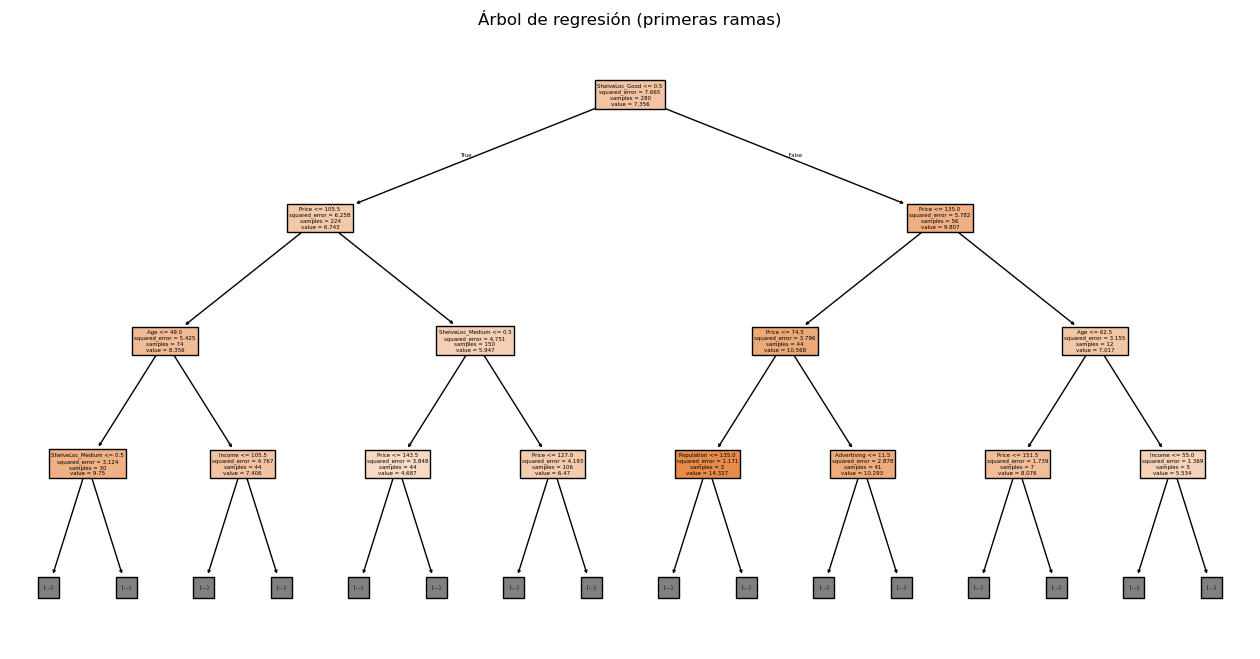

In [24]:
# Verificamos el arbol de regresión
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

# Visualizamos  las primeras ramas del árbol
plt.figure(figsize=(16, 8))
plot_tree(tree_model, filled=True, feature_names=X.columns, max_depth=3)
plt.title("Árbol de regresión (primeras ramas)")
plt.show()


Test MSE (árbol completo): 4.805


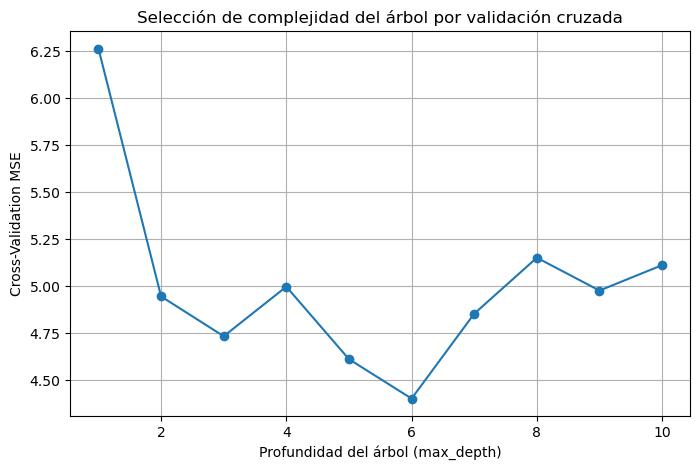

Profundidad óptima del árbol: 6


In [25]:
#  Calculamos el MSE en el conjunto de prueba

y_pred = tree_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"\nTest MSE (árbol completo): {test_mse:.3f}")

#Seleccionamos la  complejidad óptima con Cross-Validation

depths = range(1, 11)
cv_scores = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    
    scores = -cross_val_score(
        model, X_train, y_train, scoring="neg_mean_squared_error", cv=10
    )
    cv_scores.append(np.mean(scores))

# Graficamos el error de validación cruzada
plt.figure(figsize=(8, 5))
plt.plot(depths, cv_scores, marker='o')
plt.xlabel("Profundidad del árbol (max_depth)")
plt.ylabel("Cross-Validation MSE")
plt.title("Selección de complejidad del árbol por validación cruzada")
plt.grid(True)
plt.show()

# Hallamos la  profundidad óptima
best_depth = depths[np.argmin(cv_scores)]
print(f"Profundidad óptima del árbol: {best_depth}")

Test MSE (árbol podado): 4.143

Diferencia en MSE: 0.663


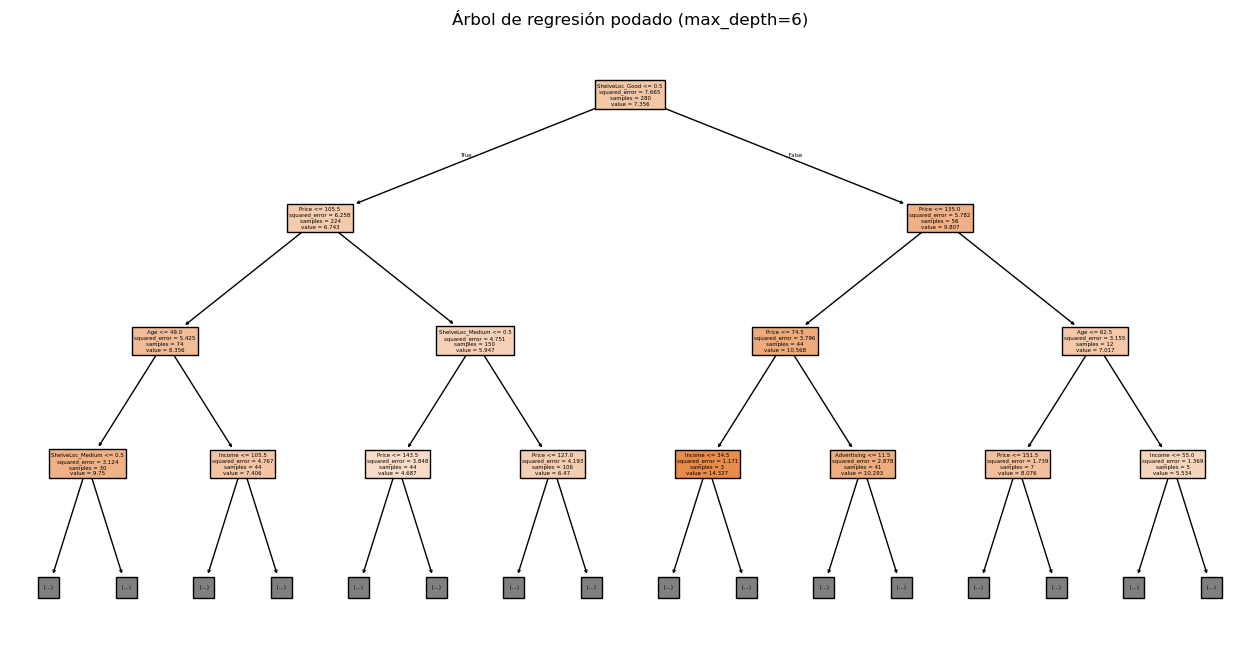

In [26]:
# Ajustamos el árbol podado (profundidad óptima)

pruned_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
pruned_tree.fit(X_train, y_train)

# Evaluamos en el conjunto de prueba
y_pred_pruned = pruned_tree.predict(X_test)
test_mse_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f"Test MSE (árbol podado): {test_mse_pruned:.3f}")

# Realizamos la comparacion de errores
print(f"\nDiferencia en MSE: {test_mse - test_mse_pruned:.3f}")

# Graficamos  el árbol final (podado)

plt.figure(figsize=(16, 8))
plot_tree(pruned_tree, filled=True, feature_names=X.columns, max_depth=3)
plt.title(f"Árbol de regresión podado (max_depth={best_depth})")
plt.show()

En la Parte C, el árbol completo obtuvo un MSE de prueba de 4.805, mientras que el árbol podado, con una profundidad óptima de 6, redujo el error a 4.143.
Esto significa que al aplicar la poda se logró una mejor capacidad de generalización, evitando el sobreajuste que presentaba el árbol inicial.

En otras palabras, el árbol completo era demasiado complejo y se ajustaba demasiado a los datos de entrenamiento, mientras que el árbol podado consiguió un mejor equilibrio entre complejidad y precisión.
La diferencia de 0.663 en el MSE refleja una mejora moderada pero significativa en el desempeño del modelo al predecir sobre datos nuevos.